In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import uuid
import time

from concurrent.futures import ThreadPoolExecutor
from itertools import product

In [11]:
from src.Tile import Tile
from src import augmentation, io_utils, s3_utils, image_utils, image_metrics

In [12]:
import logging
from src.logging_utils import get_logger

logger = get_logger(__name__)

logger.setLevel(logging.INFO)

# Defining params based on details

I am going to take advantage of `tile_uniform_contrast` from image_metrics to tell me how "busy" the tile is; as "busy" tiles - ones with a lot of details - would require different tuning compared to simple tiles; first one would benefit from cutting; second ones would benefit from assembling.

In [5]:
contrast_pieces = 8

def get_max_fragmentation_depth(tile):
    i = 0
    contrast = image_metrics.tile_uniform_contrast(tile, contrast_pieces * 4**i)
    if contrast > 0:
        while contrast > 0:
            i += 1
            contrast = image_metrics.tile_uniform_contrast(tile, contrast_pieces * 4**i)
    return i

def get_max_augmentation_depth(tile):
    i = 0
    contrast = image_metrics.tile_uniform_contrast(tile, contrast_pieces)
    if contrast == 0:
        while contrast == 0:
            i += 1
            tile = tile.assemble_quadrant_unfold(0, 0)
            contrast = image_metrics.tile_uniform_contrast(tile, contrast_pieces)

    return i

In [6]:
def enrich_wrapper(local_filepath, key):
    start = time.clock()
    tile = Tile(cv2.cvtColor(cv2.imread(local_filepath), cv2.COLOR_BGR2RGB))
    key = '{}/{}'.format(key, str(uuid.uuid4()))
    
    max_fragmentation_depth = get_max_fragmentation_depth(tile)
    max_augmentation_depth = get_max_augmentation_depth(tile)
    
    augmentation.enrich(tile, key, 
                        max_fragmentation_depth=max_fragmentation_depth,
                        max_augmentation_depth=max_augmentation_depth)
    
    end = time.clock()
    logger.info('Finished processing {} in {:.3f}s'.format(local_filepath, end - start))

In [7]:
folder = 'dataset_processed'
files = ['{}/{}'.format(folder, _) for _ in os.listdir(folder)  if _.endswith(".jpg")]

key = 'deep-azulejo/synthetic_dataset_20200919'
s3_utils.delete_from_s3(key)

In [8]:
with ThreadPoolExecutor() as executor:
    [
        executor.submit(enrich_wrapper, file, key)
        for file in files
    ]

## Let's checkout how many images I generated and how they look like!

In [13]:
key = 'deep-azulejo/synthetic_dataset_20200919'

In [14]:
len(s3_utils.get_image_list_from_s3(key))

347635

Sample images:

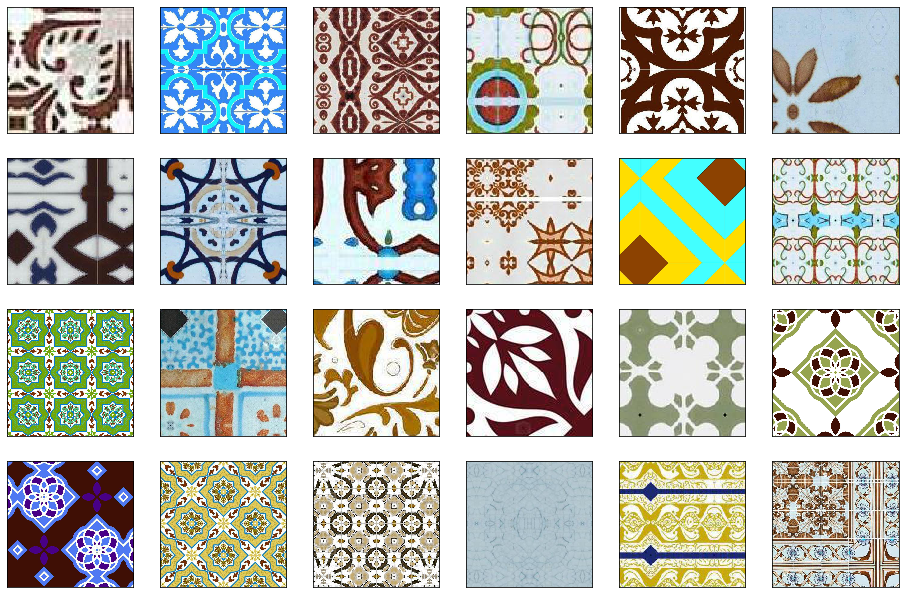

In [15]:
io_utils.plot_sample_files_from_s3(key, 24)

More sample images:

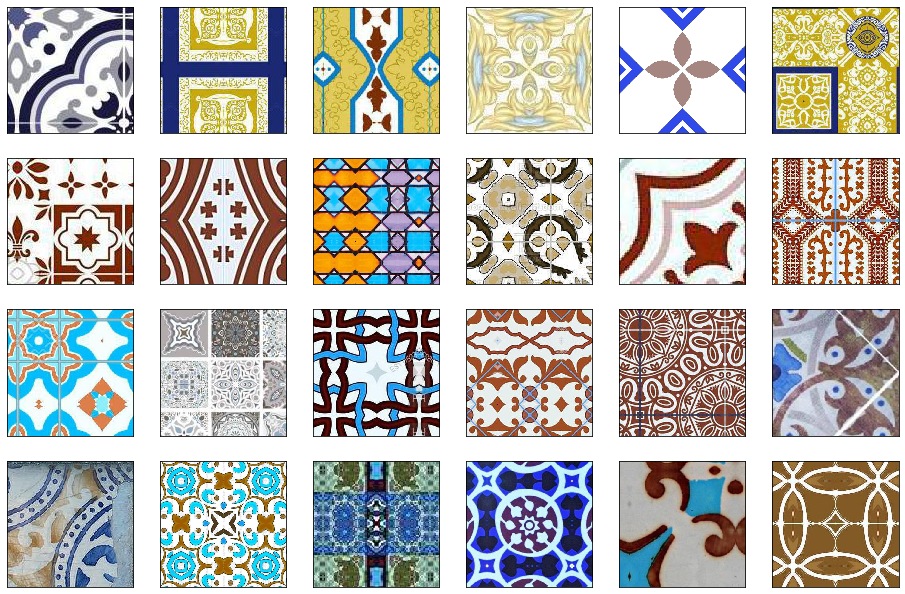

In [16]:
io_utils.plot_sample_files_from_s3(key, 24)

I think most of them look really good, and data size inflation from 1808 images to 347635 is a success.